# Exploring the publisher annotations

_All groups: established, non-established, governmental/institutional, other, not\_clear_

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest, ttest_ind
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from util import gather_dataset, z_score_per_worker, z_score_per_task

In [86]:
def load_data(
    publisher_annotations_path: str, claimant_annotations_path: str
) -> pd.DataFrame:
    """Load the annotations annotated publishers, their category, and their average score into a dataframe"""
    publisher_df = pd.read_csv(publisher_annotations_path)
    claimant_df = gather_dataset(claimant_annotations_path)

    # perform an inner join on the publisher and claimant dataframes on the publisher name
    joint_df = pd.merge(publisher_df, claimant_df, on='publisher')

    del publisher_df, claimant_df # unload dfs from memory to prevent crashes

    # optionally z-score the scores before performing the statistical tests
    joint_df = z_score_per_task(joint_df)
    joint_df = z_score_per_worker(joint_df)

    # return joint_df

    # group all the claimants by the publisher and calculate the average score for each publisher
    # make sure to keep the mainstream or alternative category
    grouped_df = joint_df.groupby(['publisher', 'category'], as_index=False).agg(
        {'score': 'mean', 'z_score_worker': 'mean', 'z_score_task': 'mean'}
    )

    return grouped_df

stats_df = load_data('./annotations/publisher_annotations.csv', './data/claimant_data_processed/')
stats_df.head()

/home/bbjoverbeek/master_thesis/util.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(
/home/bbjoverbeek/master_thesis/util.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(


,publisher,category,score,z_score_worker,z_score_task
0,21st Century Wire,not established,2.417664,1.774801e-17,-0.070536
1,@berkeleywellness,other,2.507514,1.177608e-17,-0.075999
2,ABC News,established,4.002075,-4.906614e-18,0.045651
3,AGE OF AUTISM,not established,1.969742,1.150113e-17,-0.035269
4,Activist Post,not established,2.332694,3.302175e-17,0.247459


<Axes: title={'center': 'Distribution of Publishers per Category'}, xlabel='category'>

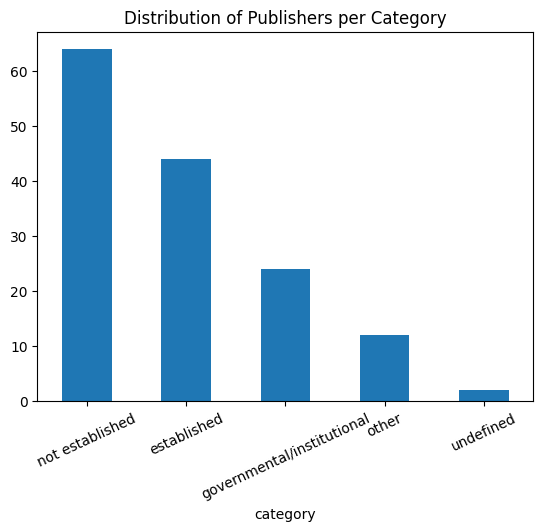

In [87]:
stats_df.value_counts('category').plot(kind='bar', title='Distribution of Publishers per Category', rot=25)

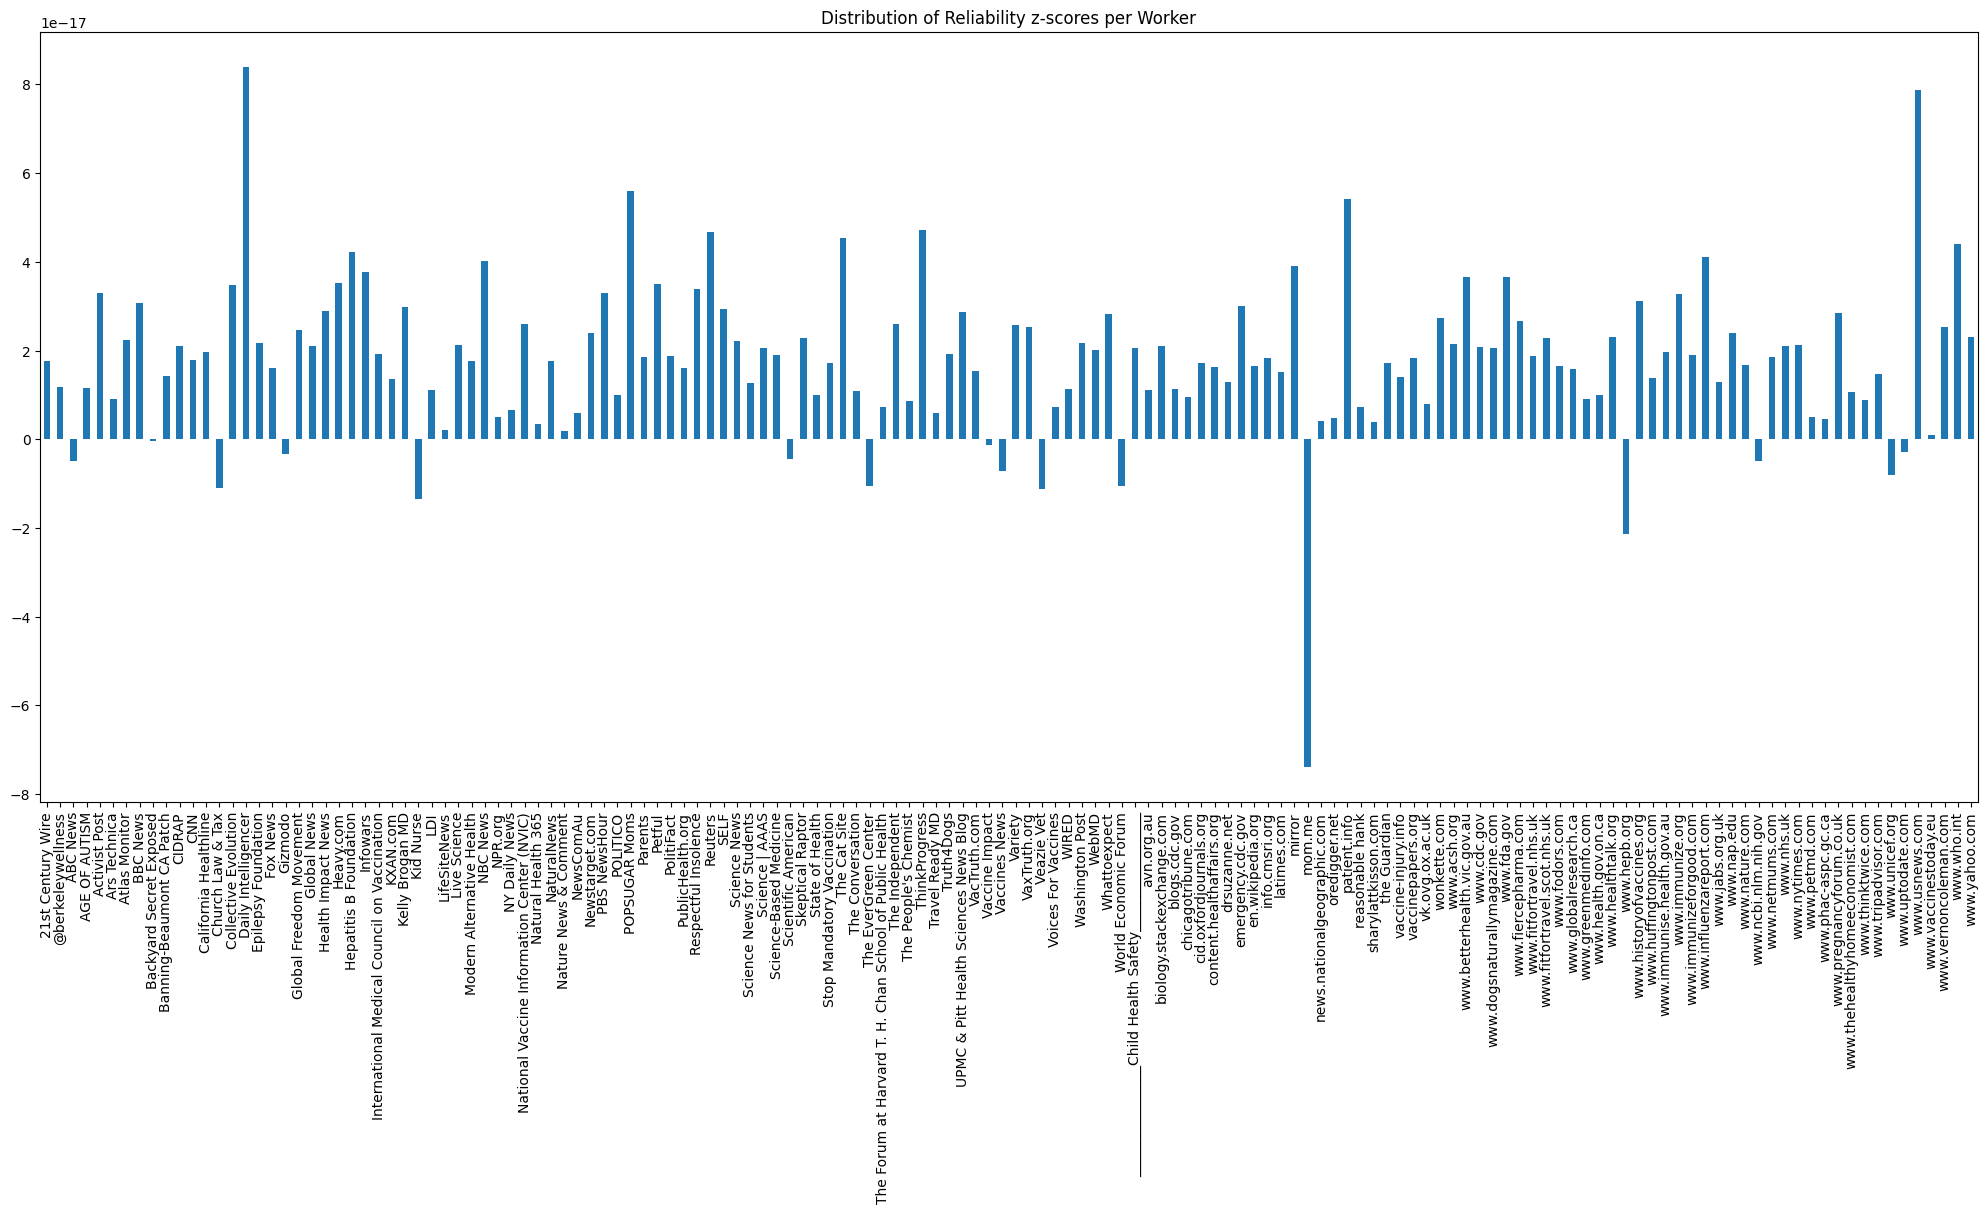

In [88]:
plot = stats_df['z_score_worker'].plot(kind='bar', title='Distribution of Reliability z-scores per Worker', figsize=(25,10))
plot.set_xticklabels(stats_df['publisher'])
plt.show()

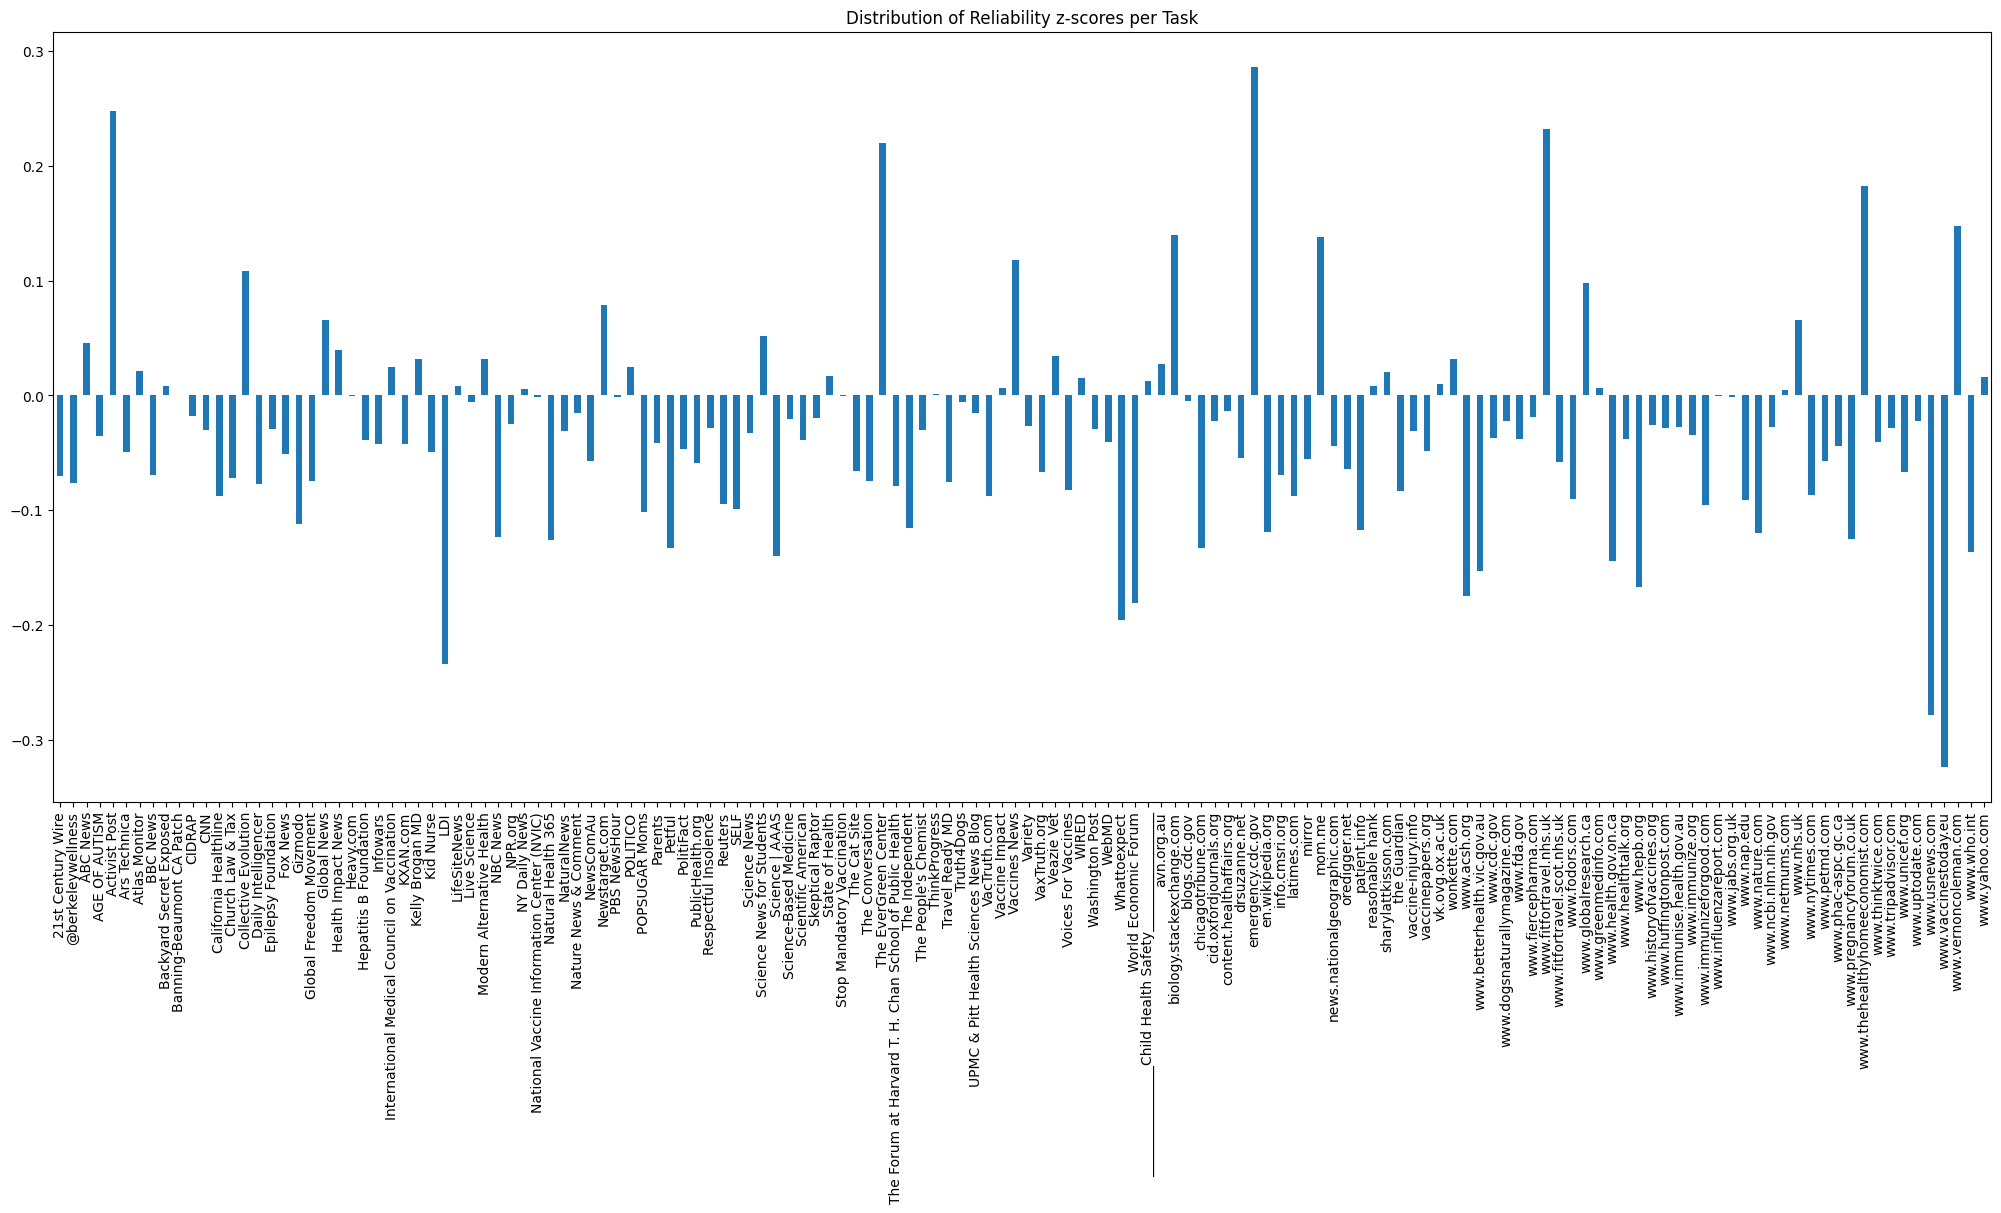

In [89]:
plot = stats_df['z_score_task'].plot(kind='bar', title='Distribution of Reliability z-scores per Task', figsize=(25,10))
plot.set_xticklabels(stats_df['publisher'])
plt.show()

In [90]:
# because the worker z-score average per publisher is much smaller, find a factor to be able to visualize their polarities
# factor = abs(stats_df['z_score_task'].mean()/stats_df['z_score_worker'].mean())
# print(f'multiplying worker z-score with {factor}')
# stats_df['z_score_worker_multiplied'] = stats_df['z_score_worker'].apply(lambda score: score * factor)

# then plot both plots in one graph
# stats_df.plot(x='publisher', y=['z_score_worker_multiplied', 'z_score_task'], kind='bar', figsize=(35, 10), title='Comparison of the Reliability z-scores per Task and per Worker (multiplied)')

### Established vs not-established statistics

In [91]:
from typing import Literal
score_column: Literal['score', 'z_score_worker', 'z_score_task'] = 'score'

In [92]:
# filter df on only established and not established sources
df_filtered2 = stats_df[
    (stats_df['category'] == 'established') | (stats_df['category'] == 'not established')
]

df_filtered2.head()

,publisher,category,score,z_score_worker,z_score_task
0,21st Century Wire,not established,2.417664,1.774801e-17,-0.070536
2,ABC News,established,4.002075,-4.906614e-18,0.045651
3,AGE OF AUTISM,not established,1.969742,1.150113e-17,-0.035269
4,Activist Post,not established,2.332694,3.302175e-17,0.247459
5,Ars Technica,established,3.198252,9.143285e-18,-0.049286


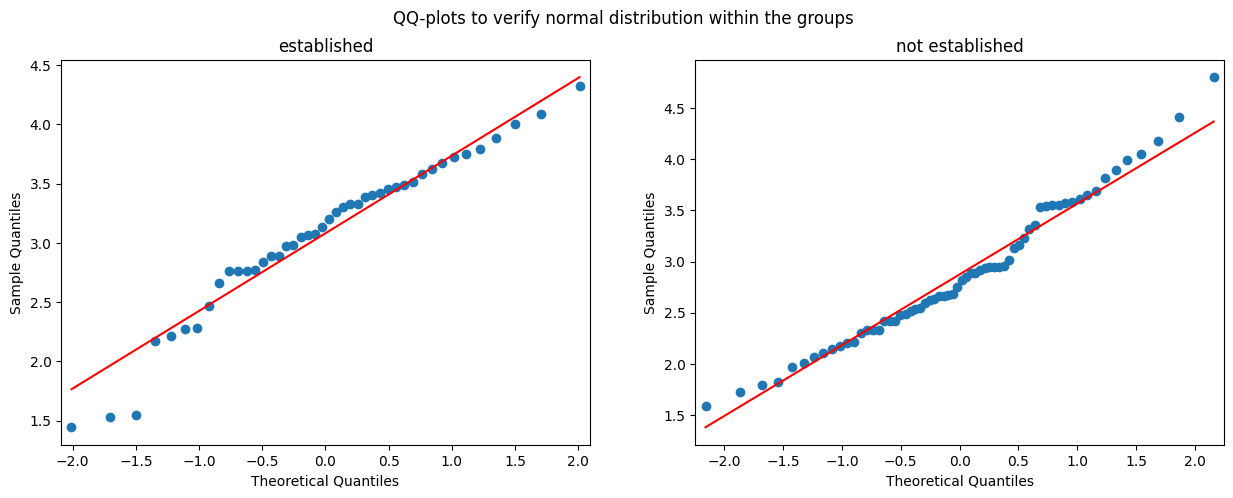

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('QQ-plots to verify normal distribution within the groups')

linetype: Literal['s','45'] = 's'

sm.qqplot(df_filtered2[df_filtered2['category'] == 'established'][score_column], line=linetype, ax=ax[0]) 
ax[0].set_title('established')

sm.qqplot(df_filtered2[df_filtered2['category'] == 'not established'][score_column], line=linetype, ax=ax[1]) 
ax[1].set_title('not established')

plt.show()

[]

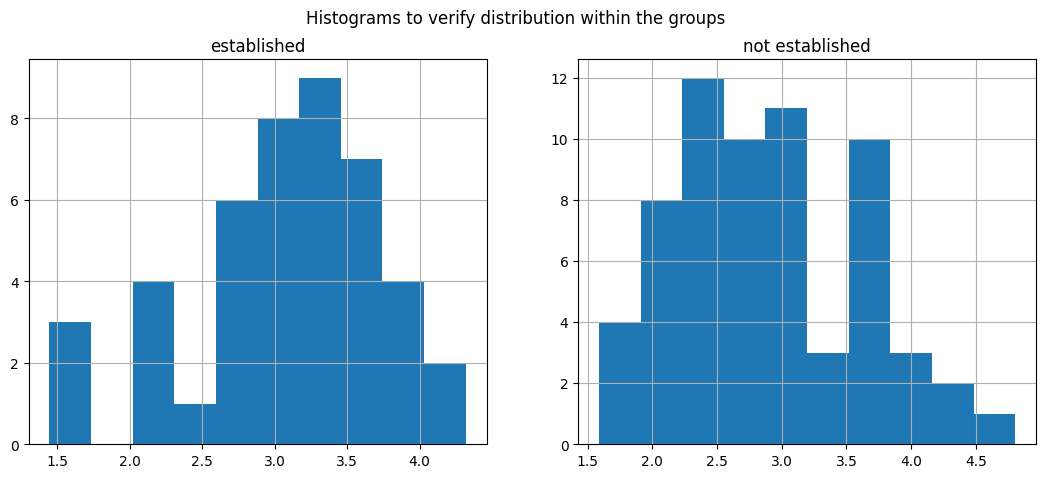

In [96]:
# distribution within each group
fig, ax = plt.subplots(1, 2, figsize=(13,5))
fig.suptitle('Histograms to verify distribution within the groups')

df_filtered2[df_filtered2['category'] == 'established'][score_column].hist(ax=ax[0])
ax[0].set_title('established')

df_filtered2[df_filtered2['category'] == 'not established'][score_column].hist(ax=ax[1])
ax[1].set_title('not established')

plt.plot()

In [100]:
# test for normal distribution
alpha = 0.05
for category in ['established', 'not established']:
    print(f'{category:<50}', end='')
    result = normaltest(df_filtered2[df_filtered2['category'] == category][score_column])
    print(f'statistic: {result.statistic:<6.3f} - p-value: {result.pvalue:.3f}', end=' ')
    print(f'-> {"not normal" if result.pvalue < alpha else "normal"}')

established                                       statistic: 4.538  - p-value: 0.103 -> normal
not established                                   statistic: 2.926  - p-value: 0.232 -> normal


<Axes: title={'center': 'score'}, xlabel='category'>

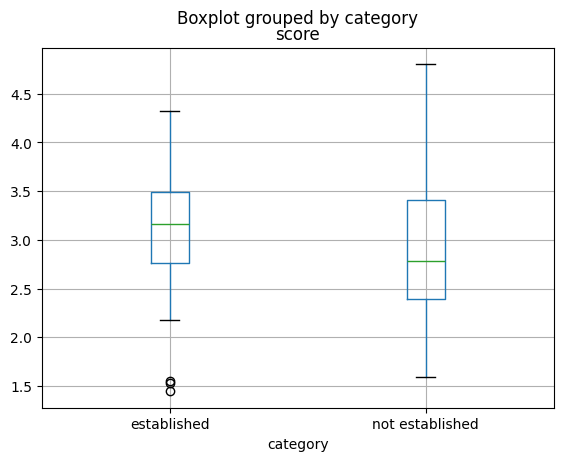

In [101]:
# create boxplot per category
df_filtered2.boxplot(column=score_column, by='category')

In [104]:
# convert the category column to a binary column
df_filtered2.loc[:, 'category'] = df_filtered2['category'].map(
    {'established': 0, 'not established': 1, 0:0, 1:1} # last two are for the case when the column is already binary
)

result = ttest_ind(
    df_filtered2[score_column].to_numpy(), df_filtered2['category'].to_numpy().astype(int)
)

print(
    f't-statistic: {result.statistic}\np-value: {result.pvalue}\ndegrees of freedom: {result.df}'
)

t-statistic: 29.031468073253226
p-value: 3.7217215049206056e-76
degrees of freedom: 214.0


### Established / not established / governmental-institutional / other statistics

In [105]:
# filter df to remove `cannot find` items
df_filtered4 = stats_df[
    (stats_df['category'] != 'undefined')
]

# print(f'The resulting categories are: {df_filtered4["category"].unique()}')

df_filtered4.head()

,publisher,category,score,z_score_worker,z_score_task
0,21st Century Wire,not established,2.417664,1.774801e-17,-0.070536
1,@berkeleywellness,other,2.507514,1.177608e-17,-0.075999
2,ABC News,established,4.002075,-4.906614e-18,0.045651
3,AGE OF AUTISM,not established,1.969742,1.150113e-17,-0.035269
4,Activist Post,not established,2.332694,3.302175e-17,0.247459


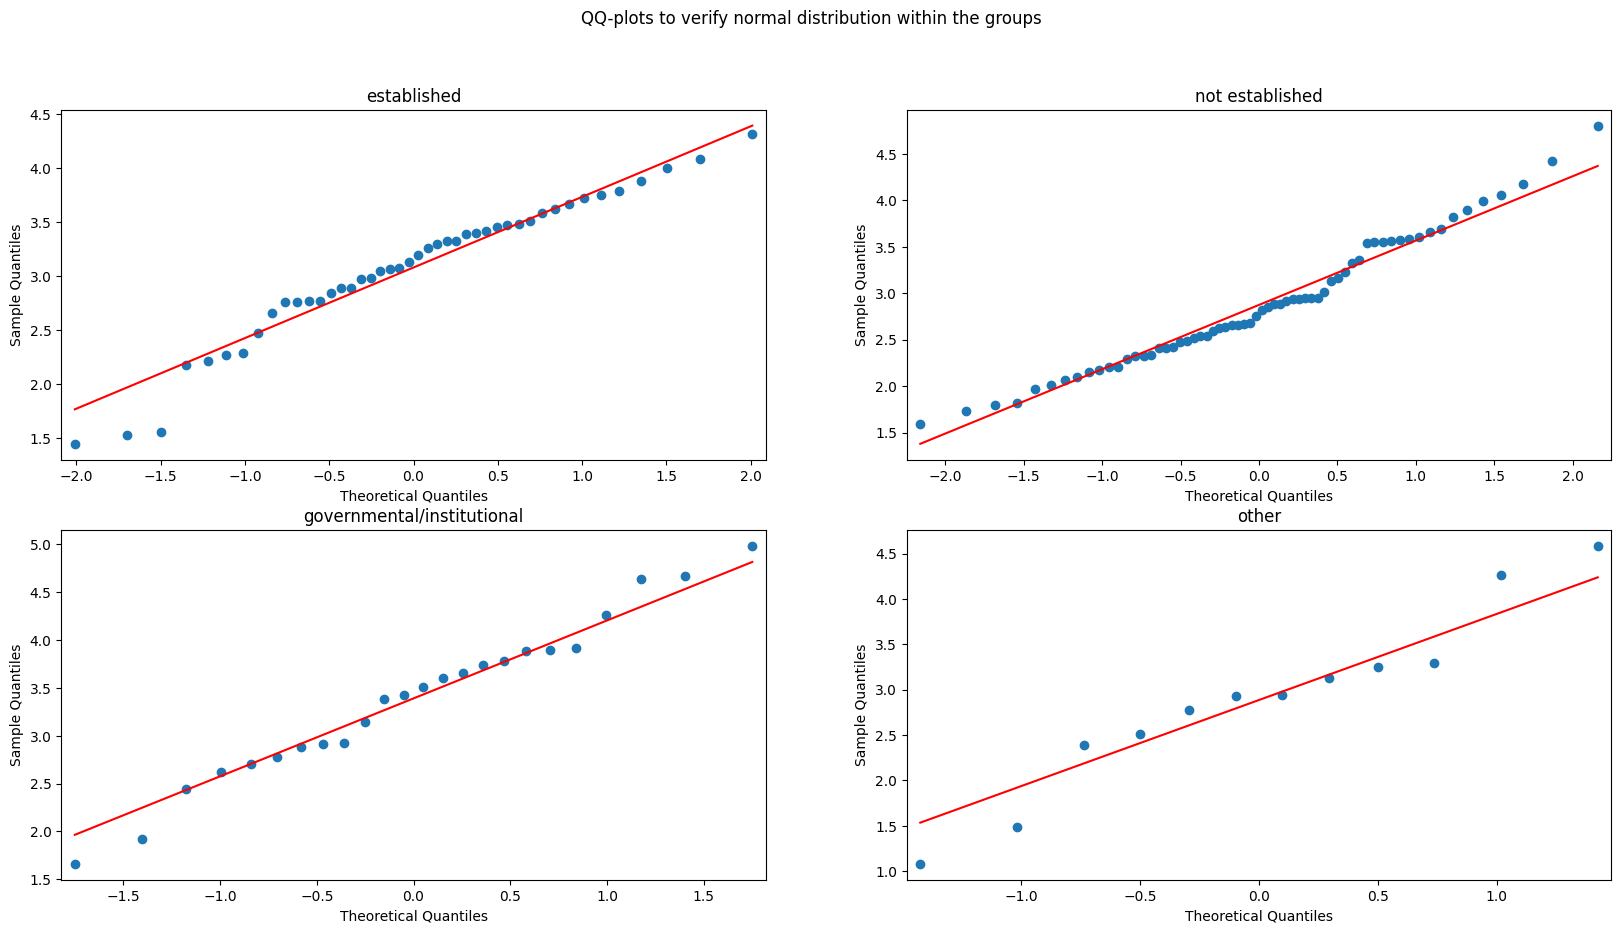

In [106]:
from typing import Literal

# distribution within each group
fig, ax = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('QQ-plots to verify normal distribution within the groups')

linetype: Literal['s','45'] = 's'

sm.qqplot(df_filtered4[df_filtered4['category'] == 'established'][score_column], line=linetype, ax=ax[0][0]) 
ax[0][0].set_title('established')

sm.qqplot(df_filtered4[df_filtered4['category'] == 'not established'][score_column], line=linetype, ax=ax[0][1]) 
ax[0][1].set_title('not established')

sm.qqplot(df_filtered4[df_filtered4['category'] == 'governmental/institutional'][score_column], line=linetype, ax=ax[1][0]) 
ax[1][0].set_title('governmental/institutional')

sm.qqplot(df_filtered4[df_filtered4['category'] == 'other'][score_column], line=linetype, ax=ax[1][1]) 
ax[1][1].set_title('other')

plt.show()


Text(0.5, 1.0, 'other')

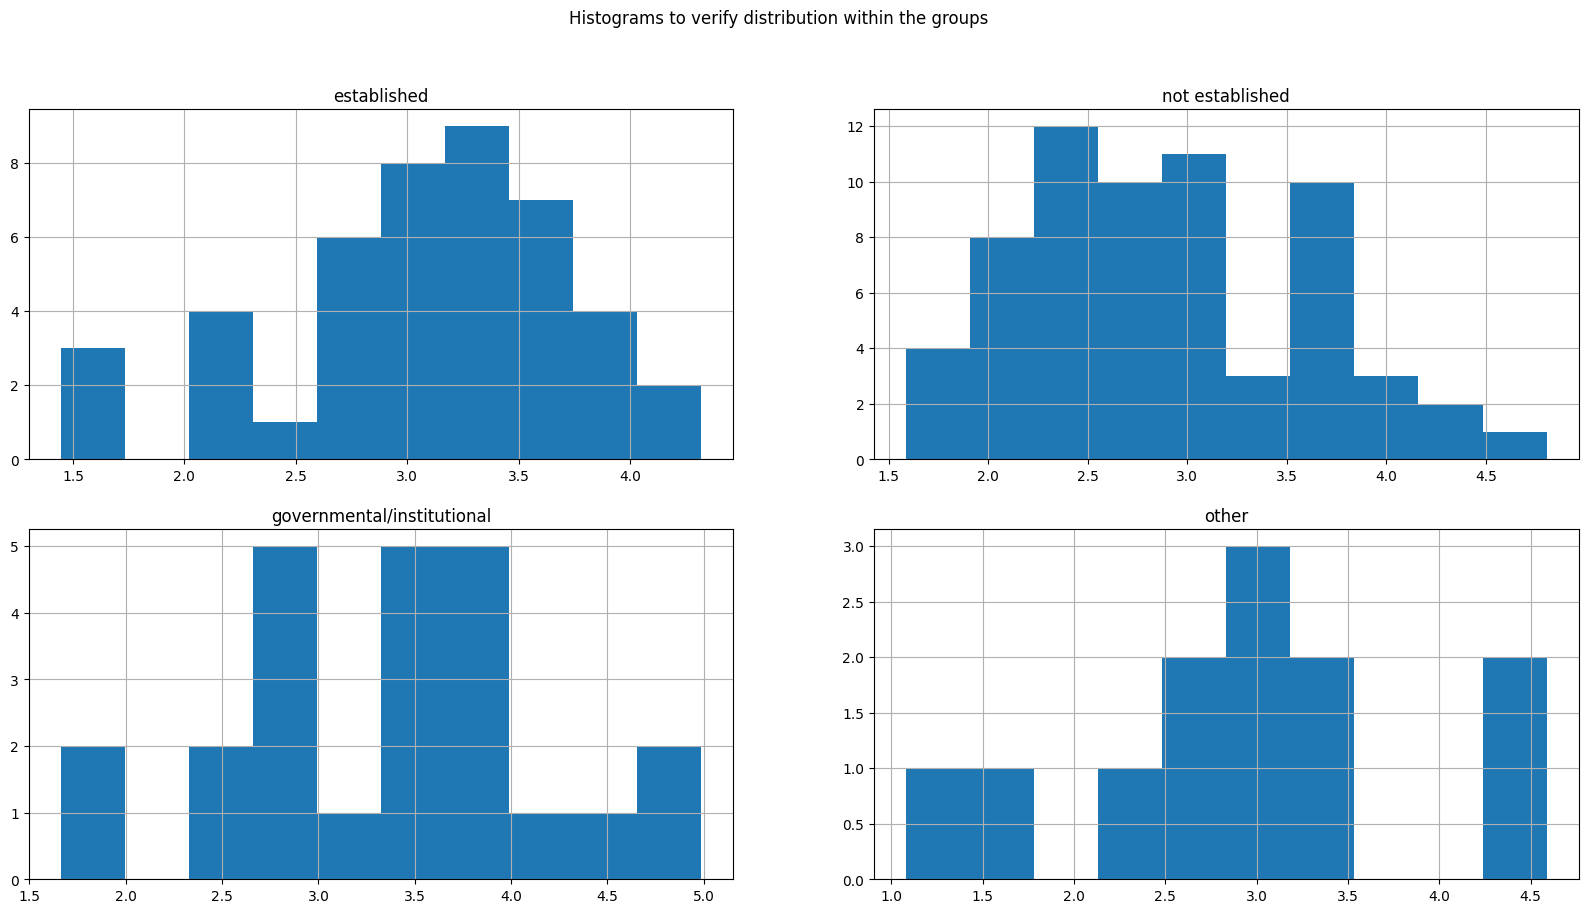

In [107]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('Histograms to verify distribution within the groups')

df_filtered4[df_filtered4['category'] == 'established'][score_column].hist(ax=ax[0][0])
ax[0][0].set_title('established')

df_filtered4[df_filtered4['category'] == 'not established'][score_column].hist(ax=ax[0][1])
ax[0][1].set_title('not established')

df_filtered4[df_filtered4['category'] == 'governmental/institutional'][score_column].hist(ax=ax[1][0])
ax[1][0].set_title('governmental/institutional')

df_filtered4[df_filtered4['category'] == 'other'][score_column].hist(ax=ax[1][1])
ax[1][1].set_title('other')


In [108]:
# test for normal distribution
alpha = 0.05
for category in ['established', 'not established', 'governmental/institutional', 'other']:
    print(f'{category:<50}', end='')
    result = normaltest(df_filtered4[df_filtered4['category'] == category][score_column])
    print(f'statistic: {result.statistic:<6.3f} - p-value: {result.pvalue:.3f}', end=' ')
    print(f'-> {"not normal" if result.pvalue < alpha else "normal"}')

established                                       statistic: 4.538  - p-value: 0.103 -> normal
not established                                   statistic: 2.926  - p-value: 0.232 -> normal
governmental/institutional                        statistic: 0.053  - p-value: 0.974 -> normal
other                                             statistic: 0.282  - p-value: 0.868 -> normal


/home/bbjoverbeek/master_thesis/env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


<Axes: title={'center': 'score'}, xlabel='category'>

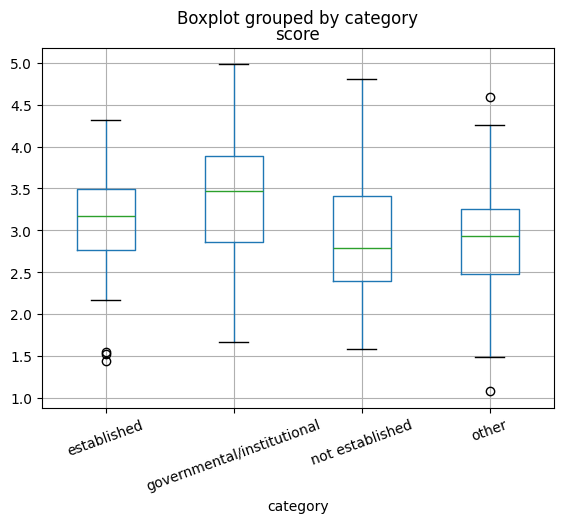

In [109]:
# create boxplot per category
df_filtered4.boxplot(column=score_column, by='category', rot=20)

In [110]:
model = ols(f'{score_column} ~ C(category)', data=df_filtered4).fit()

print(model.summary())

sm.stats.anova_lm(model, typ=1)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     3.079
Date:                Tue, 25 Jun 2024   Prob (F-statistic):             0.0296
Time:                        13:03:15   Log-Likelihood:                -158.53
No. Observations:                 144   AIC:                             325.1
Df Residuals:                     140   BIC:                             336.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

,df,sum_sq,mean_sq,F,PR(>F)
C(category),3.0,5.029723,1.676574,3.079358,0.029588
Residual,140.0,76.223824,0.544456,NaN,NaN
